In [4]:
import numpy as np
import numpy.linalg as linalg
import pandas as pd
import AnalysisFunction as af

### Loading Cosmic Chronometers data

In [2]:
zHz, Hzi, errHz = np.genfromtxt('data/32CCdata.dat', comments='#', usecols=(0,1,2), unpack=True, delimiter=',')
zmod, imf, slib, sps, spsooo = np.genfromtxt('data/data_MM20.dat', comments='#', usecols=(0,1,2,3,4), unpack=True)

### CC covariance matrix

In [3]:
cov_mat_diag = np.zeros((len(zHz), len(zHz)), dtype='float64') 

for i in range(len(zHz)):
    cov_mat_diag[i,i] = errHz[i]**2#Erros estatísticos

#Erros sistemáticos
imf_intp = np.interp(zHz, zmod, imf)/100
spsooo_intp = np.interp(zHz, zmod, spsooo)/100

cov_mat_imf = np.zeros((len(zHz), len(zHz)), dtype='float64')
cov_mat_spsooo = np.zeros((len(zHz), len(zHz)), dtype='float64')

for i in range(len(zHz)):
    for j in range(len(zHz)):
        cov_mat_imf[i,j] = Hzi[i] * imf_intp[i] * Hzi[j] * imf_intp[j]
        cov_mat_spsooo[i,j] = Hzi[i] * spsooo_intp[i] * Hzi[j] * spsooo_intp[j]
        
#Sistemático+estatístico:
cov_mat = cov_mat_spsooo+cov_mat_imf+cov_mat_diag
inv_cov_mat = linalg.inv(cov_mat)

### Function to load Pantheon+SH0ES data and covariance

In [4]:
def build_data(datafile,SH0ES):
    """
    Run once at the start to load in the data vectors.
    
    Returns x, y where x is the independent variable (redshift in this case)
    and y is the Gaussian-distribured measured variable (magnitude in this case).
    """
    
    global origlen, wwPS, wwPPlus, cepheid_distance, is_calibrator, zHELPS, zHELPPlus

    print("Loading data from {}".format(datafile))
    data = pd.read_csv(datafile, sep=r'\s+')
    origlen = len(data)
    
    if SH0ES:
        ww = (data['zHD']>0.01) | (np.array(data['IS_CALIBRATOR'],dtype=bool))
        wwPS = ww
        zHELPS = data['zHEL'][ww]
    else:
        ww = (data['zHD']>0.01)
        wwPPlus = ww
        zHELPPlus = data['zHEL'][ww]

    zCMB = data['zHD'][ww] #use the vpec corrected redshift for zCMB 
    
    m_obs = data['m_b_corr'][ww]
    if SH0ES:
        is_calibrator = data['IS_CALIBRATOR'][ww]
        cepheid_distance = data['CEPH_DIST'][ww]

    return zCMB, m_obs

def build_covariance(covdatafile, SH0ES):
    """
    Run once at the start to build the covariance matrix for the data
    The file format for the covariance has the first line as an integer
    indicating the number of covariance elements, and the the subsequent
    lines being the elements.
    This function reads in the file and the nasty for loops trim down the covariance
    to match the only rows of data that are used for cosmology    
    """
    print("Loading covariance from {}".format(covdatafile))


    f = open(covdatafile)
    line = f.readline()
    if SH0ES:
        n = int(len(zCMBPS))
        ww = wwPS
    else:
        n = int(len(zCMBPPlus))
        ww = wwPPlus
    C = np.zeros((n,n))
    ii = -1
    jj = -1
    mine = 999
    maxe = -999
    for i in range(origlen):
        jj = -1
        if ww[i]:
            ii += 1
        for j in range(origlen):
            if ww[j]:
                jj += 1
            val = float(f.readline())
            if ww[i]:
                if ww[j]:
                    C[ii,jj] = val
    f.close()
    
    print('Done')

        # Return the covariance; the parent class knows to invert this
        # later to get the precision matrix that we need for the likelihood.
    return C

### Loading Pantheon+SH0ES data and covariance

In [5]:
zCMBPS, m_obsPS = build_data('data/Pantheon+SH0ES.dat',SH0ES=True)

covPS = build_covariance('data/Pantheon+SH0ES_STAT+SYS.cov', SH0ES=True)
invcovPS = linalg.inv(covPS)

Loading data from data/Pantheon+SH0ES.dat
Loading covariance from data/Pantheon+SH0ES_STAT+SYS.cov
Done


### Loading Pantheon+ data and covariance

In [6]:
zCMBPPlus, m_obsPPlus = build_data('data/Pantheon+SH0ES.dat',SH0ES=False)

covPPlus = build_covariance('data/Pantheon+SH0ES_STAT+SYS.cov', SH0ES=False)
invcovPPlus = linalg.inv(covPPlus)

Loading data from data/Pantheon+SH0ES.dat
Loading covariance from data/Pantheon+SH0ES_STAT+SYS.cov
Done


### Model functions

In [7]:
def Ez(z,theta, pade):
    if pade == 21:
        M, H0, q0, j0 = theta
        a0 = H0
        a1 = (H0*(6 + 10*j0 + 12*q0 + 7*j0*q0 - 3*q0**2 - 6*q0**3))/(3*(j0 - q0**2))
        a2 = (H0*(12 + 14*j0 + 3*j0**2 + 36*q0 + 22*j0*q0 + 24*q0**2 + 2*j0*q0**2 - 6*q0**3 - 3*q0**4))/(6*(j0 - q0**2))
        b1 = (6 + 7*j0 + 12*q0 + 4*j0*q0 - 3*q0**3)/(3*(j0 - q0**2))
        H = (a0+a1*z+a2*z**2)/(1+b1*z)

    elif pade == 22:
        M, H0, q0, j0, s0 = theta
        a0 = H0
        a1 = (H0*(-24 + 4*j0 + 8*j0**2 - 84*q0 + 54*j0*q0 + 10*j0**2*q0 - 114*q0**2 + 67*j0*q0**2 - 102*q0**3 + 15*j0*q0**3 - 63*q0**4 - 15*q0**5
                  + 17*s0 + 2*j0*s0 + 28*q0*s0 + 9*q0**2*s0))/(2.*(6*j0 + 3*j0**2 + 14*j0*q0 - 6*q0**2 + 2*j0*q0**2 - 12*q0**3 - 3*q0**4 + 2*s0 + 2*q0*s0))
        a2 = (H0*(-144 + 24*j0 + 108*j0**2 + 30*j0**3 - 648*q0 + 216*j0*q0 + 150*j0**2*q0 - 1188*q0**2 + 252*j0*q0**2 - 5*j0**2*q0**2 - 1188*q0**3
                  + 90*j0*q0**3 - 648*q0**4 + 60*j0*q0**4 - 180*q0**5 - 45*q0**6 + 78*s0 + 9*j0*s0 + 198*q0*s0 + 35*j0*q0*s0 + 153*q0**2*s0 +
                  15*q0**3*s0 + 4*s0**2))/(12.*(6*j0 + 3*j0**2 + 14*j0*q0 - 6*q0**2 + 2*j0*q0**2 - 12*q0**3 - 3*q0**4 + 2*s0 + 2*q0*s0))
        b1 = (24 + 8*j0 - 2*j0**2 + 84*q0 - 14*j0*q0 - 4*j0**2*q0 + 102*q0**2 - 35*j0*q0**2 + 66*q0**3 - 11*j0*q0**3 + 33*q0**4 + 9*q0**5 -
                  13*s0 - 2*j0*s0 - 20*q0*s0 - 5*q0**2*s0)/(-12*j0 - 6*j0**2 - 28*j0*q0 + 12*q0**2 - 4*j0*q0**2 + 24*q0**3 + 6*q0**4 - 4*s0 - 4*q0*s0)
        b2 = (-72*j0 - 60*j0**2 - 12*j0**3 - 180*j0*q0 - 30*j0**2*q0 + 72*q0**2 - 30*j0*q0**2 + 23*j0**2*q0**2 + 180*q0**3 + 30*j0*q0**3 +
              90*q0**4 - 24*j0*q0**4 + 9*q0**6 + 15*j0*s0 - 11*j0*q0*s0 - 15*q0**2*s0 + 3*q0**3*s0 - 4*s0**2)/(-72*j0 - 36*j0**2 - 168*j0*q0
                  + 72*q0**2 - 24*j0*q0**2 + 144*q0**3 + 36*q0**4 - 24*s0 - 24*q0*s0)
        H = (a0+a1*z+a2*z**2)/(1+b1*z+b2*z**2)
    
    return H/H0

#Distancia comovel adimensional
def DcModel(z,theta, pade):#Integrando e substituindo
    if pade == 21:
        M, H0, q0, j0 = theta
        a0 = H0
        a1 = (H0*(6 + 10*j0 + 12*q0 + 7*j0*q0 - 3*q0**2 - 6*q0**3))/(3*(j0 - q0**2))
        a2 = (H0*(12 + 14*j0 + 3*j0**2 + 36*q0 + 22*j0*q0 + 24*q0**2 + 2*j0*q0**2 - 6*q0**3 - 3*q0**4))/(6*(j0 - q0**2))
        b1 = (6 + 7*j0 + 12*q0 + 4*j0*q0 - 3*q0**3)/(3*(j0 - q0**2))
    
    elif pade == 22:
        M, H0, q0, j0, s0 = theta
        a0 = H0
        a1 = (H0*(-24 + 4*j0 + 8*j0**2 - 84*q0 + 54*j0*q0 + 10*j0**2*q0 - 114*q0**2 + 67*j0*q0**2 - 102*q0**3 + 15*j0*q0**3 - 63*q0**4 - 15*q0**5
                  + 17*s0 + 2*j0*s0 + 28*q0*s0 + 9*q0**2*s0))/(2.*(6*j0 + 3*j0**2 + 14*j0*q0 - 6*q0**2 + 2*j0*q0**2 - 12*q0**3 - 3*q0**4 + 2*s0 + 2*q0*s0))
        a2 = (H0*(-144 + 24*j0 + 108*j0**2 + 30*j0**3 - 648*q0 + 216*j0*q0 + 150*j0**2*q0 - 1188*q0**2 + 252*j0*q0**2 - 5*j0**2*q0**2 - 1188*q0**3
                  + 90*j0*q0**3 - 648*q0**4 + 60*j0*q0**4 - 180*q0**5 - 45*q0**6 + 78*s0 + 9*j0*s0 + 198*q0*s0 + 35*j0*q0*s0 + 153*q0**2*s0 +
                  15*q0**3*s0 + 4*s0**2))/(12.*(6*j0 + 3*j0**2 + 14*j0*q0 - 6*q0**2 + 2*j0*q0**2 - 12*q0**3 - 3*q0**4 + 2*s0 + 2*q0*s0))
        b1 = (24 + 8*j0 - 2*j0**2 + 84*q0 - 14*j0*q0 - 4*j0**2*q0 + 102*q0**2 - 35*j0*q0**2 + 66*q0**3 - 11*j0*q0**3 + 33*q0**4 + 9*q0**5 -
                  13*s0 - 2*j0*s0 - 20*q0*s0 - 5*q0**2*s0)/(-12*j0 - 6*j0**2 - 28*j0*q0 + 12*q0**2 - 4*j0*q0**2 + 24*q0**3 + 6*q0**4 - 4*s0 - 4*q0*s0)
        b2 = (-72*j0 - 60*j0**2 - 12*j0**3 - 180*j0*q0 - 30*j0**2*q0 + 72*q0**2 - 30*j0*q0**2 + 23*j0**2*q0**2 + 180*q0**3 + 30*j0*q0**3 +
              90*q0**4 - 24*j0*q0**4 + 9*q0**6 + 15*j0*s0 - 11*j0*q0*s0 - 15*q0**2*s0 + 3*q0**3*s0 - 4*s0**2)/(-72*j0 - 36*j0**2 - 168*j0*q0)
    
    if (a1**2-4*a0*a2) > 0:
        r1 = (-a1 + np.sqrt(a1**2-4*a2*a0))/(2*a2)
        r2 = (-a1 - np.sqrt(a1**2-4*a2*a0))/(2*a2)

        if pade == 21:        
            dc = (((1+b1*r2)/(r2-r1))*np.log(np.abs((z-r2)/(-r2)))-((1+b1*r1)/(r2-r1))*np.log(np.abs((z-r1)/(-r1))))/a2

        elif pade == 22:
            dc = (((1 + b1*r2 + r2**2)/(r2 - r1))*np.log(np.abs((z - r2)/(-r2))) - ((1 + b1*r1 + r1**2)/(r2 - r1))*np.log(np.abs((z-r1)/(-r1))) + z)/a2
        
    elif (a1**2-4*a0*a2) == 0:
        if pade == 21:
            dc = ((1 + (a1*b1)/(2*a2))*2*a2*z)/(a1*(a1/(2*a2) + z)) + (b1*np.log(2*np.abs((a2*(a1/(2*a2) + z))/a1)))/a2

        elif pade == 22:
            dc = ((b1 - (b2*a1)/(2*a2))*np.log(np.abs((2*a2*z + a1)/a1)) - (1 - (b1*a1)/(2*a2) + (b2*a1)/(4*a2**2))*(1/(a1*(2*a2*z +a1)) - b2)*z)/a2
        
    elif (a1**2-4*a0*a2) < 0:
        if pade == 21:
            dc = (b1/(2*a2))*np.log(np.abs((a0+a1*z+a2*z**2)/a0)) + (((2*a2-b1*a1))/(a2*np.sqrt(4*a2*a0-a1**2)))*(np.arctan((2*a2*z+a1)/np.sqrt(4*a2*a0-a1**2)) - np.arctan(a1/np.sqrt(4*a2*a0-a1**2)))

        elif pade == 22:
            dc = ((b2*z)/a2 + (b1/(2*a2) - (b2*a1)/(2*a2**2))*np.log(np.abs((a0+a1*z+a2*z**2)/a0)) + (((2*a2-b1*a1 - b2*(2*a2*a0 - a1**2)/a2))/(a2*np.sqrt(4*a2*a0-a1**2)))*(np.arctan((2*a2*z+a1)/np.sqrt(4*a2*a0-a1**2))
                    - np.arctan(a1/np.sqrt(4*a2*a0-a1**2))))/a2
        
    else:
        print('else')
        return None
    return (H0)*dc

#Distancia comovel transversal in pc
def dmModel(z, theta, pade):
    if pade == 21:
        M, H0, q0, j0 = theta
    elif pade == 22:
        M, H0, q0, j0, s0= theta
    
    dH = c/H0
    wk = 0
    Dcm = DcModel(z, theta, pade)
    if wk < 0:
        return dH*np.sin(np.sqrt(-wk)*Dcm)/np.sqrt(-wk)
    elif wk > 0:
        return dH*np.sinh(np.sqrt(wk)*Dcm)/np.sqrt(wk)
    return dH*Dcm

#distancia de luminosidade in pc
def dlModel(z,theta, pade):
    return (1+z)*dmModel(z,theta, pade)

def daModel(z,theta, pade):
    return dmModel(z,theta, pade)/(1+z)

def muModel(z,pars, pade):
    return 5.*np.log10(dlModel(z,pars, pade))+25

In [8]:
#Theory points for Pantheon+ and Pantheon+&SH0ES
def extract_theory_points(theory_x, theory_y, pars, SH0ES):
    """
    Run once per parameter set to extract the mean vector that our
    data points are compared to.  For the Hubble flow set, we compare to the 
    cosmological model. For the calibrators we compare to the Cepheid distances.
    """
    M = pars[0]

    # Pull out theory mu and z from the block.
    #theory_x = block[self.x_section, self.x_name]
    #theory_y = block[self.y_section, self.y_name]

    # Interpolation function of theory so we can evaluate at redshifts of the data
    f = scipy.interpolate.interp1d(theory_x, theory_y)#, kind=self.kind)
    
    if SH0ES:
        theory_ynew = zCMBPS*np.nan
        #Here we use the Cepheid host distances as the "theory". 
        #This is the 2nd rung of the distance ladder and is what calibrates M
        theory_ynew[np.array(is_calibrator,dtype='bool')] = cepheid_distance[np.array(is_calibrator,dtype='bool')]
        
        # Actually do the interpolation at the data redshifts
        zcmb = zCMBPS[~np.array(is_calibrator,dtype='bool')]
        zhel = zHELPS[~np.array(is_calibrator,dtype='bool')]
    else:
        theory_ynew = zCMBPPlus*np.nan
        # Actually do the interpolation at the data redshifts
        zcmb = zCMBPPlus
        zhel = zHELPPlus
    
    fz = f(zcmb)
    if np.any(fz<=0):
        NegDist = True
        return 1
    if SH0ES:
        theory_ynew[~np.array(is_calibrator,dtype='bool')] = 5.0*np.log10((1.0+zcmb)*(1.0+zhel)*\
                                                                          np.atleast_1d(fz))+25.
    else:
        theory_ynew = 5.0*np.log10((1.0+zcmb)*(1.0+zhel)*np.atleast_1d(fz))+25.
                
    # Add the absolute supernova magnitude and return
    #M = block[names.supernova_params, "M"]
    return theory_ynew + M

def extract_theory_pointsHz(theory_x, theory_y, pars):
    theory_ynew = zHz*np.nan  

    f = scipy.interpolate.interp1d(theory_x, theory_y)#, kind=self.kind)
    theory_ynew = np.atleast_1d(f(zHz))
    return theory_ynew

In [9]:
#Points for theory interpolation
N = 3000
zt = np.linspace(0,2.5,N)

In [10]:
def chi2(theta, dtype, pade):
    if dtype == 'PS':#Pantheon+SH0ES
        zsni = zCMBPS
        Ez2i = Ez(zsni,theta,pade)
        if np.any(Ez2i <= 0):
            return np.inf
    
        dAt = daModel(zt,theta,pade)
        NegDist = False
        mmod = extract_theory_points(zt, dAt, theta, SH0ES=True)
        if NegDist:
            return np.inf
        dm = mmod-m_obsPS
        
        return np.dot(np.dot(dm.T,invcovPS),dm)
        
    elif dtype == 'PP':#Pantheon+
        zsni = zCMBPPlus
        Ez2i = Ez(zsni,theta,pade)
        if np.any(Ez2i <= 0):
            return np.inf
    
        dAt = daModel(zt,theta,pade)
        NegDist = False
        mmod = extract_theory_points(zt, dAt, theta,SH0ES=False) #5.*np.log10((1+zsni)*(1+zheli)*dAmodi/10)#(dlmodi/10)
        if NegDist:
            return np.inf
        dmu = mmod-m_obsPPlus
        SA  = np.sum(invcovPPlus)
        Sr  = np.sum(np.dot(dmu.T,invcovPPlus))#np.sum(dmu*invcov)
        Srr = np.dot(np.dot(dmu.T,invcovPPlus),dmu)#np.sum(dmu*dmu*invcov)
        return Srr - Sr**2./SA
        
    elif dtype == 'Hz':#CC Hz
        if pade == 21:
            M, H0, q0, j0 = theta
        elif pade == 22:
            M, H0, q0, j0, s0 = theta
            
        Ezt = Ez(zt,theta,pade)
        if np.any(Ezt<0):
            return np.inf
        Hzt = H0*Ezt#Hz(zt,pars)
        Hzm = extract_theory_pointsHz(zt, Hzt, theta)
       
        dh = Hzm-Hzi
        
        return np.dot(np.dot(dh.T,inv_cov_mat),dh)
        
    else:
        print('Invalid data set...')
        return -np.inf

def lnprior(theta, pade):
    if pade == 21:
        M, H0, q0, j0 = theta
        if -19.50 < M < -19 and 40. < H0 < 100. and -2 < q0 < 2 and -5 < j0 < 5:
            return 0.0 
            
    elif pade == 22:
        M, H0, q0, j0, s0 = theta
        if -19.50 < M < -19 and 40. < H0 < 100. and -2 < q0 < 2 and -5 < j0 < 10 and -5 < s0 < 50:
            return 0.0
            
    return -np.inf

def lnlike(par, dtype, pade):
    if dtype == 'PS' or dtype == 'PP' or dtype == 'Hz':
        return -0.5*chi2(par, dtype, pade)

    elif dtype == 'PP+Hz':
        return -0.5*(chi2(par, 'PP', pade)+chi2(par, 'Hz', pade))

    elif dtype == 'PS+Hz':
        return -0.5*(chi2(par, 'PS', pade)+chi2(par, 'Hz', pade))

def lnprob(par, dtype, pade):
    lp = lnprior(par, pade)
    if not np.isfinite(lp):
        return -np.inf
    return lp+lnlike(par, dtype, pade)

In [11]:
c = 299792.458#km/s

## Pade 21

In [25]:
parlabels = ["M","H_0",'q_0','j_0']
parlabtex = ["$M$","$H_0$",'$q_0$','$j_0$']
parnames = ['M','H0','q0','j0']
par0_21=[-19.2, 73.03398760350208, -0.5280171275112104, 1]
ndim = len(par0)

par_mlHzPS_21 = par0_21
par_mlHzPP_21 = par0_21

In [44]:
resultHzPS_21 = find_bestfit(lnprob,par_mlHzPS_21, 'PS+Hz', 21)
par_mlHzPS_21=resultHzPS_21['x']
print('\n',par_mlHzPS_21,'\n')
print(resultHzPS_21,'\n')

C:\Users\nirk2\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
C:\Users\nirk2\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


Maximum likelihood result:
M  =  -19.25342616062833
H0  =  73.32843577545314
q0  =  -0.5798936872228133
j0  =  2.2693874316775626
chi2min = 1469.5326661240288
tempo total: 3.105 seg

 [-19.25342616  73.32843578  -0.57989369   2.26938743] 

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1469.5326661240288
             x: [-1.925e+01  7.333e+01 -5.799e-01  2.269e+00]
           nit: 210
          nfev: 356
 final_simplex: (array([[-1.925e+01,  7.333e+01, -5.799e-01,  2.269e+00],
                       [-1.925e+01,  7.333e+01, -5.799e-01,  2.269e+00],
                       ...,
                       [-1.925e+01,  7.333e+01, -5.799e-01,  2.269e+00],
                       [-1.925e+01,  7.333e+01, -5.799e-01,  2.269e+00]],
                      shape=(5, 4)), array([ 1.470e+03,  1.470e+03,  1.470e+03,  1.470e+03,
                        1.470e+03])) 



In [77]:
resultHzPP = find_bestfit(lnprob,par_mlHzPP, 'PP+Hz')
par_mlHzPP=resultHzPP['x']
print('\n',par_mlHzPP,'\n')
print(resultHzPP,'\n')

C:\Users\nirk2\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


Maximum likelihood result:
M  =  -19.025271998259925
H0  =  69.10433367087076
q0  =  -0.5961096963281398
j0  =  2.4549384407712926
chi2min = 1418.4627051581965
tempo total: 4.665 seg

 [-19.025272    69.10433367  -0.5961097    2.45493844] 

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1418.4627051581965
             x: [-1.903e+01  6.910e+01 -5.961e-01  2.455e+00]
           nit: 158
          nfev: 274
 final_simplex: (array([[-1.903e+01,  6.910e+01, -5.961e-01,  2.455e+00],
                       [-1.903e+01,  6.910e+01, -5.961e-01,  2.455e+00],
                       ...,
                       [-1.903e+01,  6.910e+01, -5.961e-01,  2.455e+00],
                       [-1.903e+01,  6.910e+01, -5.961e-01,  2.455e+00]],
                      shape=(5, 4)), array([ 1.418e+03,  1.418e+03,  1.418e+03,  1.418e+03,
                        1.418e+03])) 



In [95]:
nstepPS = 10000
nstep = 5000

In [96]:
samplerHzPS = run_emcee(par_mlHzPS,100,lnprob,'PS+Hz',2.0,nstepPS)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [1:18:16<00:00,  2.13it/s]

Acceptance fraction: [0.5963 0.5953 0.6008 0.5962 0.6067 0.5958 0.5919 0.5969 0.5946 0.5952
 0.5934 0.5894 0.5961 0.5915 0.597  0.6012 0.5912 0.5886 0.5926 0.6007
 0.6006 0.5975 0.5879 0.5963 0.5892 0.5979 0.5854 0.5994 0.5928 0.5966
 0.5975 0.5985 0.5914 0.594  0.5934 0.5995 0.6042 0.5978 0.5972 0.6033
 0.5973 0.6144 0.5905 0.587  0.5885 0.5895 0.5917 0.5918 0.5876 0.5881
 0.6003 0.5944 0.5957 0.5934 0.5906 0.5908 0.5956 0.5892 0.5851 0.5962
 0.597  0.5917 0.5949 0.5909 0.6029 0.6034 0.6033 0.602  0.5893 0.5911
 0.5925 0.5852 0.5939 0.5929 0.5944 0.6006 0.5851 0.5979 0.6011 0.5913
 0.5929 0.5996 0.5938 0.5914 0.6011 0.5924 0.5962 0.5896 0.6085 0.5966
 0.6033 0.6009 0.6002 0.5906 0.5914 0.5992 0.5967 0.5914 0.5914 0.5951]
Minimum acceptance: 0.5851
Maximum acceptance: 0.6144


In [97]:
tauHzPS = samplerHzPS.get_autocorr_time(tol=0)
print(tauHzPS)
tauHzPSmax = np.amax(tauHzPS)
r = nstepPS/tauHzPSmax
print(r)
if(r>50):
    print('Convergiu! :)')
else:
    print('Nao convergiu... :(')

[45.84002924 45.71558579 46.11517735 46.72866438]
214.0014086019803
Convergiu! :)


<Figure size 640x480 with 0 Axes>

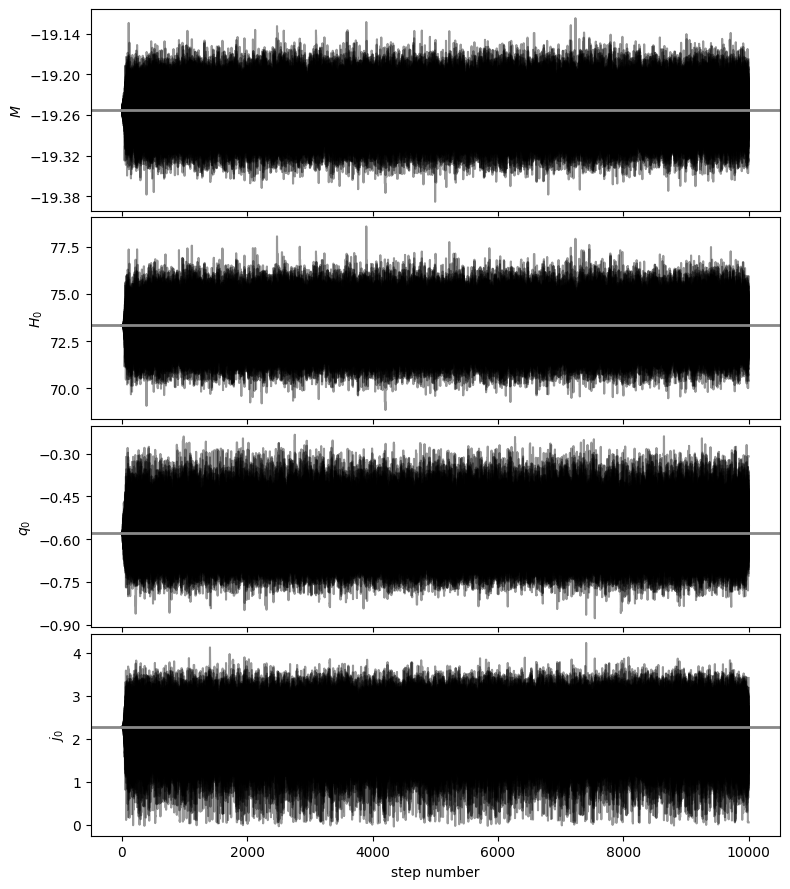

In [98]:
plot_chains(samplerHzPS,par_mlHzPS,parlabtex)

In [99]:
samplesHzPS = burninthin(samplerHzPS,tauHzPS)

(45000, 4)


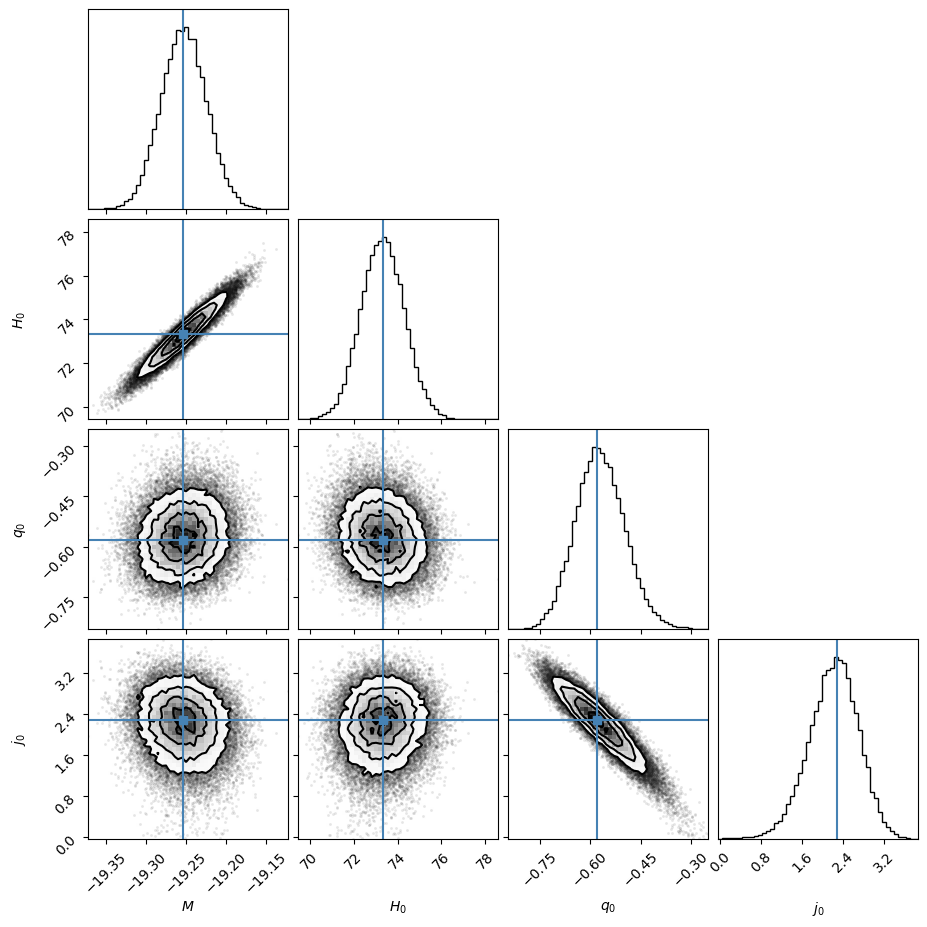

In [100]:
plot_cornertriangle(samplesHzPS,parlabtex,par_mlHzPS)

In [69]:
from getdist import plots, MCSamples
import getdist, IPython
print('Version: ',getdist.__version__)

Version:  1.6.1


In [101]:
gsamplesHzPS = MCSamples(samples=samplesHzPS,names=parnames,labels=parlabels)
gsamplesHzPS.updateSettings({'contours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


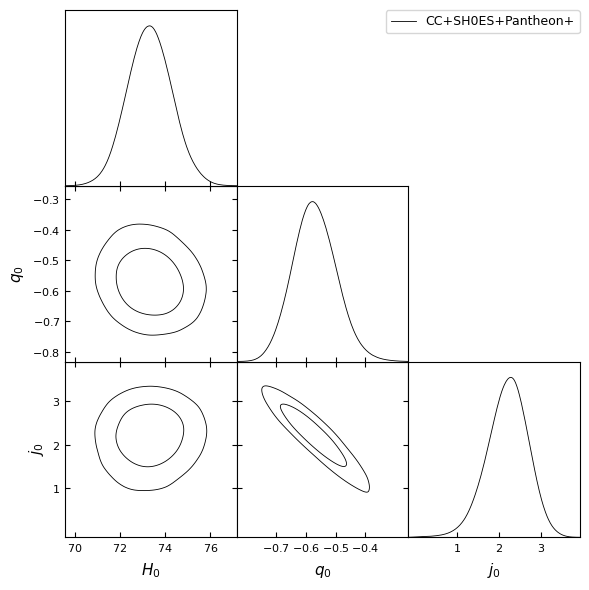

In [103]:
g = plots.getSubplotPlotter()#width_inch=10)
g.triangle_plot([gsamplesHzPS], ('H0', 'q0', 'j0'), filled=False,legend_labels=['CC+SH0ES+Pantheon+'])
g.export('fig/g_HzPS_NoM-triangle.pdf')

In [104]:
for i in range(len(par0)):
    for j in range(1,4):
        print(gsamplesHzPS.getInlineLatex(parnames[i],limit=j))
        
print(gsamplesHzPS.getTable().tableTex())#[68.0,0.645,0.60,1.736,0.231]

M = -19.253\pm 0.028
M = -19.253^{+0.057}_{-0.056}
M = -19.253^{+0.085}_{-0.085}
H_0 = 73.32\pm 0.98
H_0 = 73.3^{+2.0}_{-1.9}
H_0 = 73.3^{+2.9}_{-2.9}
q_0 = -0.570\pm 0.073
q_0 = -0.57^{+0.15}_{-0.14}
q_0 = -0.57^{+0.25}_{-0.20}
j_0 = 2.20^{+0.52}_{-0.43}
j_0 = 2.20^{+0.95}_{-0.99}
j_0 = 2.2^{+1.3}_{-1.9}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$M              $} & $-19.253^{+0.057}_{-0.056} $\\

{\boldmath$H_0            $} & $73.3^{+2.0}_{-1.9}        $\\

{\boldmath$q_0            $} & $-0.57^{+0.15}_{-0.14}     $\\

{\boldmath$j_0            $} & $2.20^{+0.95}_{-0.99}      $\\
\hline
\end{tabular}


In [80]:
samplerHzPP = run_emcee(par_mlHzPP,100,lnprob,'PP+Hz',2.0,nstep)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [30:39<00:00,  2.72it/s]

Acceptance fraction: [0.5628 0.545  0.5496 0.5484 0.5684 0.5554 0.557  0.5608 0.546  0.554
 0.554  0.5324 0.5546 0.5478 0.5568 0.5396 0.5568 0.537  0.5548 0.5436
 0.5644 0.5574 0.5416 0.5496 0.5562 0.555  0.5416 0.5506 0.5526 0.5446
 0.5574 0.5582 0.5474 0.5496 0.5542 0.559  0.546  0.55   0.559  0.557
 0.5446 0.5692 0.5436 0.5512 0.5332 0.5552 0.5764 0.5462 0.5552 0.5538
 0.5414 0.5484 0.5444 0.5504 0.546  0.5392 0.5598 0.5546 0.5518 0.5472
 0.5584 0.5482 0.5532 0.5424 0.5564 0.5354 0.5502 0.547  0.5402 0.5468
 0.5334 0.546  0.5474 0.5496 0.5674 0.5578 0.5544 0.5506 0.556  0.5208
 0.5552 0.5458 0.5386 0.56   0.5282 0.5568 0.558  0.534  0.5348 0.5562
 0.5534 0.5468 0.548  0.5512 0.5342 0.5566 0.55   0.5596 0.537  0.5662]
Minimum acceptance: 0.5208
Maximum acceptance: 0.5764


In [81]:
tauHzPP = samplerHzPP.get_autocorr_time(tol=0)
print(tauHzPP)
tauHzPPmax = np.amax(tauHzPP)
r = nstep/tauHzPPmax
print(r)
print(tauHzPPmax)
if(r>50):
    print('Convergiu! :)')
else:
    print('Nao convergiu... :(')

[56.03649565 50.19145541 47.70704534 49.23363505]
89.22756396451669
56.03649565047366
Convergiu! :)


<Figure size 640x480 with 0 Axes>

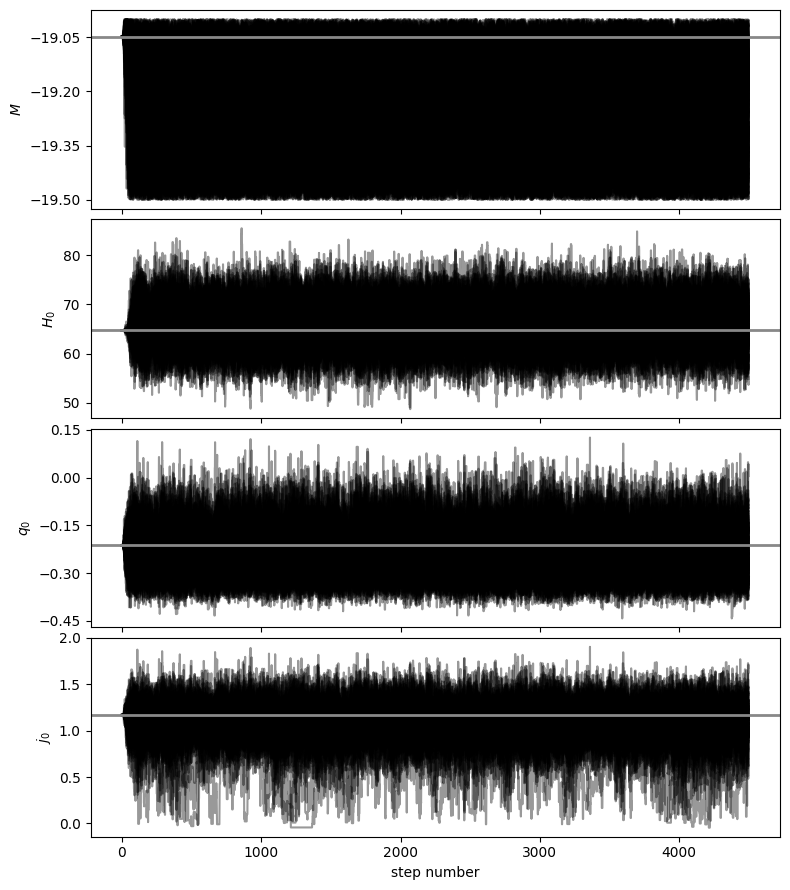

In [27]:
plot_chains(samplerHzPP,par_mlHzPP,parlabtex)

In [82]:
samplesHzPP = burninthin(samplerHzPP,tauHzPP)

(21200, 4)


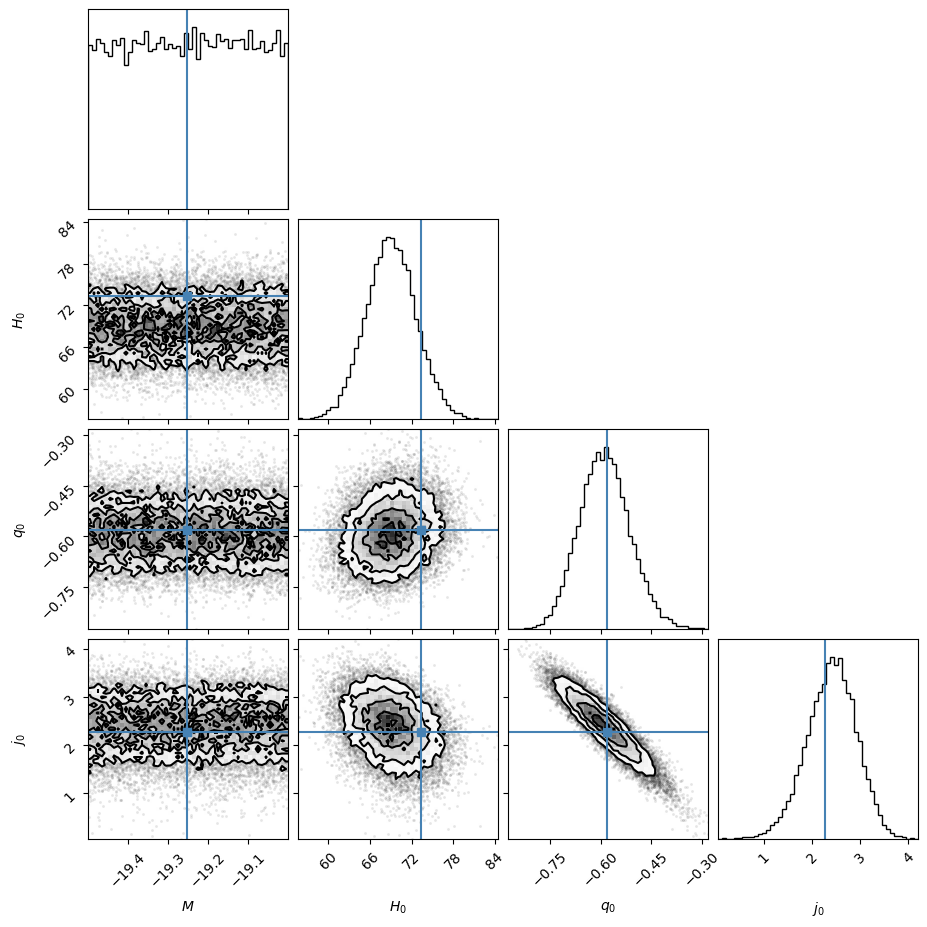

In [83]:
plot_cornertriangle(samplesHzPP,parlabtex,par_mlHzPS)

In [84]:
gsamplesHzPP = MCSamples(samples=samplesHzPP,names=parnames,labels=parlabels)
gsamplesHzPP.updateSettings({'contours': [0.682689492137, 0.954499736104, 0.997300203937]})

Removed no burn in


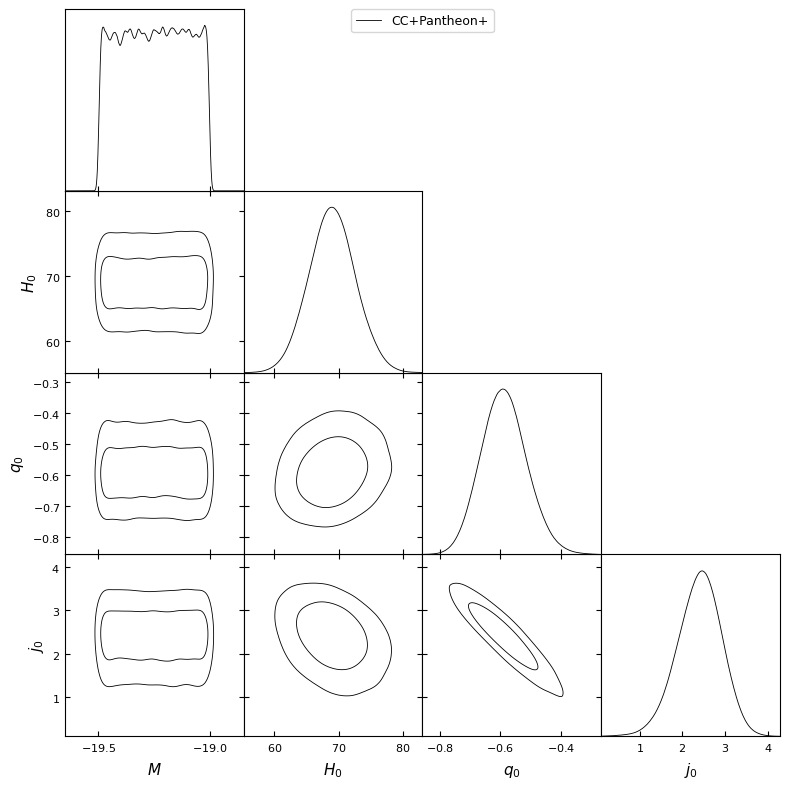

In [94]:
g = plots.getSubplotPlotter()#width_inch=10)
g.triangle_plot([gsamplesHzPP], filled=False,legend_labels=['CC+Pantheon+'])
g.export('fig/g_HzPP_All-triangle.pdf')

In [91]:
for i in range(len(par0)):
    for j in range(1,4):
        print(gsamplesHzPP.getInlineLatex(parnames[i],limit=j))
        
print(gsamplesHzPP.getTable().tableTex())#[68.0,0.645,0.60,1.736,0.231]

M = -19.25\pm 0.14
M = -19.25^{+0.24}_{-0.24}
M = -19.25^{+0.25}_{-0.25}
H_0 = 69.0\pm 3.6
H_0 = 69.0^{+7.3}_{-7.1}
H_0 = 69^{+10}_{-10}
q_0 = -0.588^{+0.070}_{-0.079}
q_0 = -0.59^{+0.16}_{-0.14}
q_0 = -0.59^{+0.25}_{-0.20}
j_0 = 2.40^{+0.55}_{-0.48}
j_0 = 2.40^{+0.98}_{-1.1}
j_0 = 2.4^{+1.5}_{-1.8}
\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$M              $} & $-19.25^{+0.24}_{-0.24}    $\\

{\boldmath$H_0            $} & $69.0^{+7.3}_{-7.1}        $\\

{\boldmath$q_0            $} & $-0.59^{+0.16}_{-0.14}     $\\

{\boldmath$j_0            $} & $2.40^{+0.98}_{-1.1}       $\\
\hline
\end{tabular}


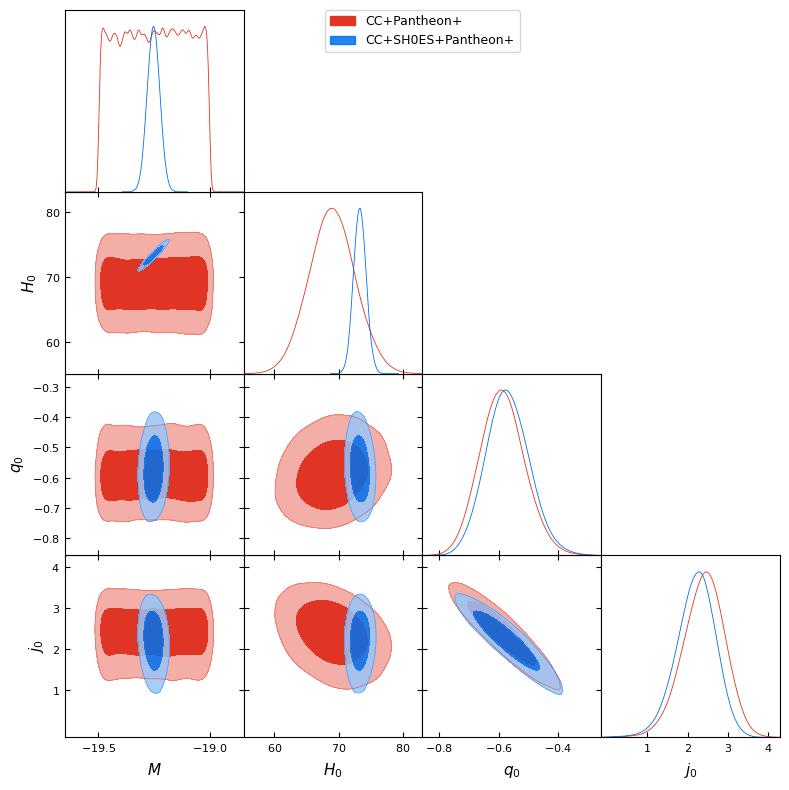

In [116]:
g = plots.getSubplotPlotter()#width_inch=10)
g.triangle_plot([gsamplesHzPP,gsamplesHzPS], filled=True,\
legend_labels=['CC+Pantheon+','CC+SH0ES+Pantheon+'])
g.export('fig/g_Comp_All-triangle.pdf')

In [114]:
MC_result(samplesHzPS, par_mlHzPS, parnames)

MCMC result:
M = -19.25305 +0.02838 +0.05672 -0.02841 -0.05614 (median: -19.25307, ml: -19.25343)
H0 = 73.31750 +0.97749 +1.99449 -0.98167 -1.92758 (median: 73.31412, ml: 73.32844)
q0 = -0.56986 +0.07245 +0.15421 -0.07277 -0.14059 (median: -0.57233, ml: -0.57989)
j0 = 2.19995 +0.48085 +0.90375 -0.47648 -1.05258 (median: 2.22507, ml: 2.26939)


In [117]:
MC_result(samplesHzPP, par_mlHzPP, parnames)

MCMC result:
M = -19.24904 +0.16913 +0.23767 -0.17068 -0.23925 (median: -19.24808, ml: -19.02527)
H0 = 69.01737 +3.58229 +7.28686 -3.61942 -7.12051 (median: 68.97963, ml: 69.10433)
q0 = -0.58779 +0.07458 +0.15775 -0.07531 -0.14371 (median: -0.58954, ml: -0.59611)
j0 = 2.39683 +0.51264 +0.97874 -0.51665 -1.10739 (median: 2.41964, ml: 2.45494)


## Pade 22

In [13]:
parlabels_22 = ["M","H_0",'q_0','j_0','s_0']
parlabtex_22 = ["$M$","$H_0$",'$q_0$','$j_0$','$s_0$']
parnames_22 = ['M','H0','q0','j0','s_0']
par0_22 = [-19.2, 73.03398760350208, -0.5280171275112104, 1, 20]
ndim_22 = len(par0_22)

par_mlHzPP_22 = par0_22
par_mlHzPS_22 = par0_22

In [16]:
resultHzPP_22 = find_bestfit(lnprob,parnames_22,par_mlHzPP_22, 'PP+Hz', 22)
par_mlHzPP_22=resultHzPP_22['x']
print('\n',par_mlHzPP_22,'\n')
print(resultHzPP_22,'\n')

C:\Users\nirk2\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
C:\Users\nirk2\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
C:\Users\nirk2\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
C:\Users\nirk2\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


Maximum likelihood result:
M  =  -19.00000000826776
H0  =  69.44280352318654
q0  =  -0.4284906494308622
j0  =  2.525538780004357
s_0  =  5.778114666489937
chi2min = 1445.5021288217715
tempo total: 6.603 seg

 [-19.00000001  69.44280352  -0.42849065   2.52553878   5.77811467] 

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1445.5021288217715
             x: [-1.900e+01  6.944e+01 -4.285e-01  2.526e+00  5.778e+00]
           nit: 583
          nfev: 966
 final_simplex: (array([[-1.900e+01,  6.944e+01, ...,  2.526e+00,
                         5.778e+00],
                       [-1.900e+01,  6.944e+01, ...,  2.526e+00,
                         5.778e+00],
                       ...,
                       [-1.900e+01,  6.944e+01, ...,  2.526e+00,
                         5.778e+00],
                       [-1.900e+01,  6.944e+01, ...,  2.526e+00,
                         5.778e+00]], shape=(6, 5)), array([ 1.446e+03,  1.446e+0

In [19]:
nstepPP_22 = 7500
samplerHzPP_22 = run_emcee(par_mlHzPP_22,100,lnprob,'PP+Hz', 22, 2.0,nstepPP_22)

100%|██████████████████████████████████████████████████████████████████████████████| 7500/7500 [47:05<00:00,  2.65it/s]

Acceptance fraction: [0.48293333 0.49306667 0.49746667 0.4932     0.50013333 0.47813333
 0.48946667 0.4908     0.48613333 0.04093333 0.48826667 0.49586667
 0.48333333 0.48493333 0.49426667 0.48333333 0.47946667 0.4896
 0.48826667 0.49613333 0.492      0.47853333 0.48773333 0.47213333
 0.488      0.49386667 0.4        0.49813333 0.5012     0.50666667
 0.4876     0.48666667 0.4884     0.4944     0.4864     0.4828
 0.394      0.48906667 0.48226667 0.48706667 0.48106667 0.47493333
 0.4856     0.49506667 0.47706667 0.48986667 0.48066667 0.4932
 0.48333333 0.49213333 0.486      0.48693333 0.48306667 0.4784
 0.49173333 0.48053333 0.49       0.4916     0.48493333 0.49466667
 0.48773333 0.06933333 0.49026667 0.48253333 0.49066667 0.14493333
 0.49026667 0.50146667 0.5044     0.4892     0.49093333 0.40626667
 0.5012     0.49706667 0.48346667 0.49266667 0.4816     0.47106667
 0.48573333 0.47746667 0.3328     0.50053333 0.49666667 0.49106667
 0.19613333 0.48386667 0.494      0.48933333 0.46733333 0

In [20]:
tauHzPP_22 = samplerHzPP_22.get_autocorr_time(tol=0)
print(tauHzPP_22)
tauHzPP_22max = np.amax(tauHzPP_22)
r = nstepPP_22/tauHzPP_22max
print(r)
print(tauHzPP_22max)
if(r>50):
    print('Convergiu! :)')
else:
    print('Nao convergiu... :(')

[ 98.51321639 102.93737255 126.38442759 128.69565294 123.48674025]
58.277026678149504
128.6956529443542
Convergiu! :)


In [29]:
samplesHzPP_22 = burninthin(samplerHzPP_22,tauHzPP_22)

(14700, 5)


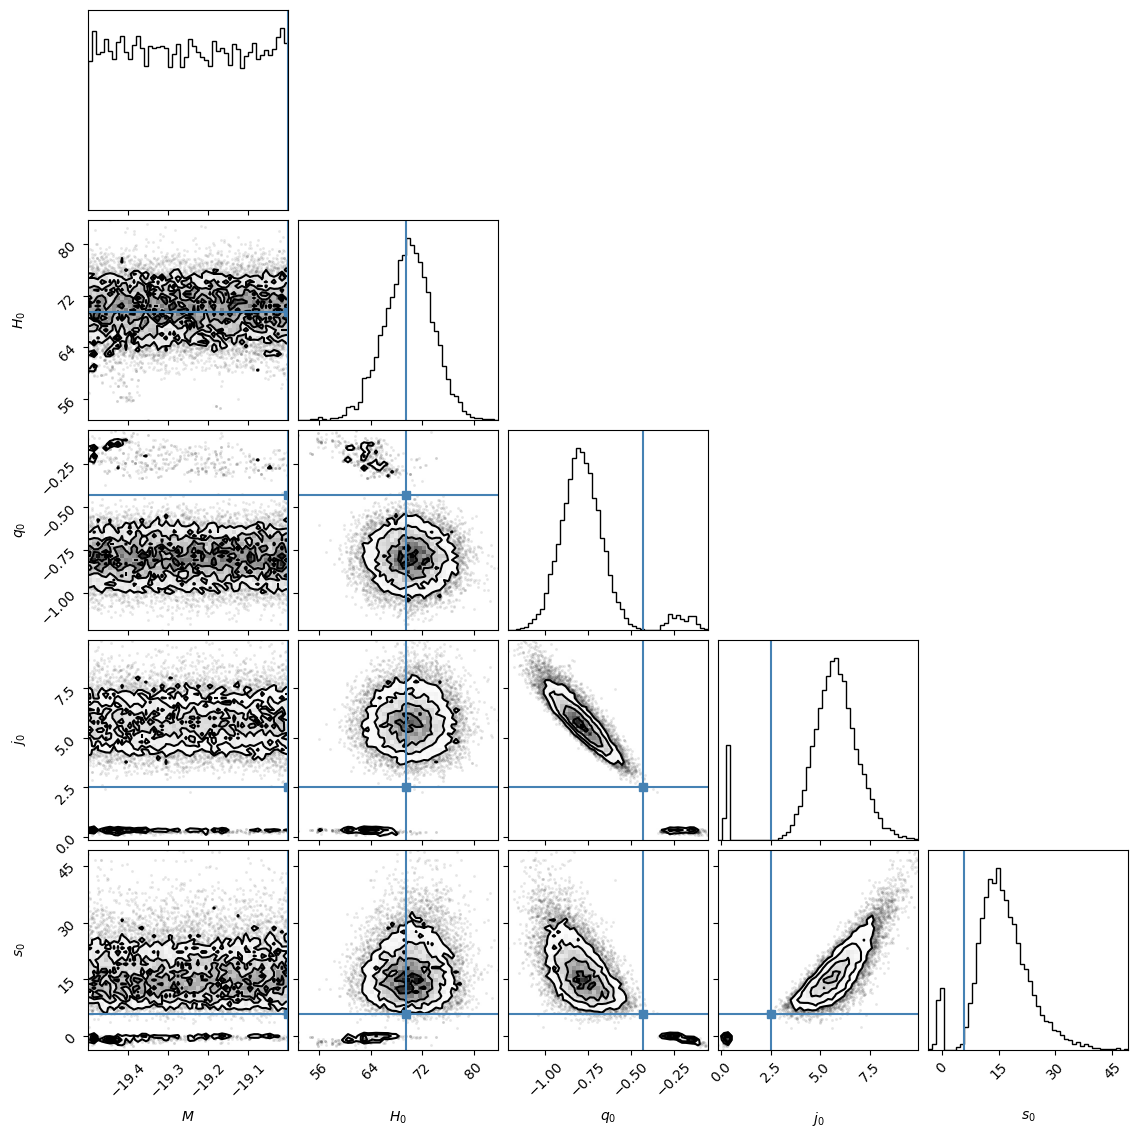

In [30]:
plot_cornertriangle(samplesHzPP_22,parlabtex_22,par_mlHzPP_22)

In [31]:
MC_result(samplesHzPP_22, par_mlHzPP_22, parnames_22)

MCMC result:
M = -19.25033 +0.17268 +0.23961 -0.17162 -0.23755 (median: -19.25050, ml: -19.00000)
H0 = 69.83671 +3.67287 +7.31749 -3.71059 -7.72826 (median: 69.94420, ml: 69.44280)
q0 = -0.76475 +0.10786 +0.56648 -0.13878 -0.25451 (median: -0.78706, ml: -0.42849)
j0 = 5.55008 +1.28316 +2.56784 -0.96893 -5.25883 (median: 5.70871, ml: 2.52554)
s_0 = 16.06691 +6.55624 +16.63677 -5.94759 -16.61554 (median: 15.49440, ml: 5.77811)


In [24]:
gsamplesHzPP_22 = MCSamples(samples=samplesHzPP_22,names=parnames_22,labels=parlabels_22)
gsamplesHzPP_22.updateSettings({'contours': [0.682689492137, 0.954499736104, 0.997300203937]})

NameError: name 'MCSamples' is not defined

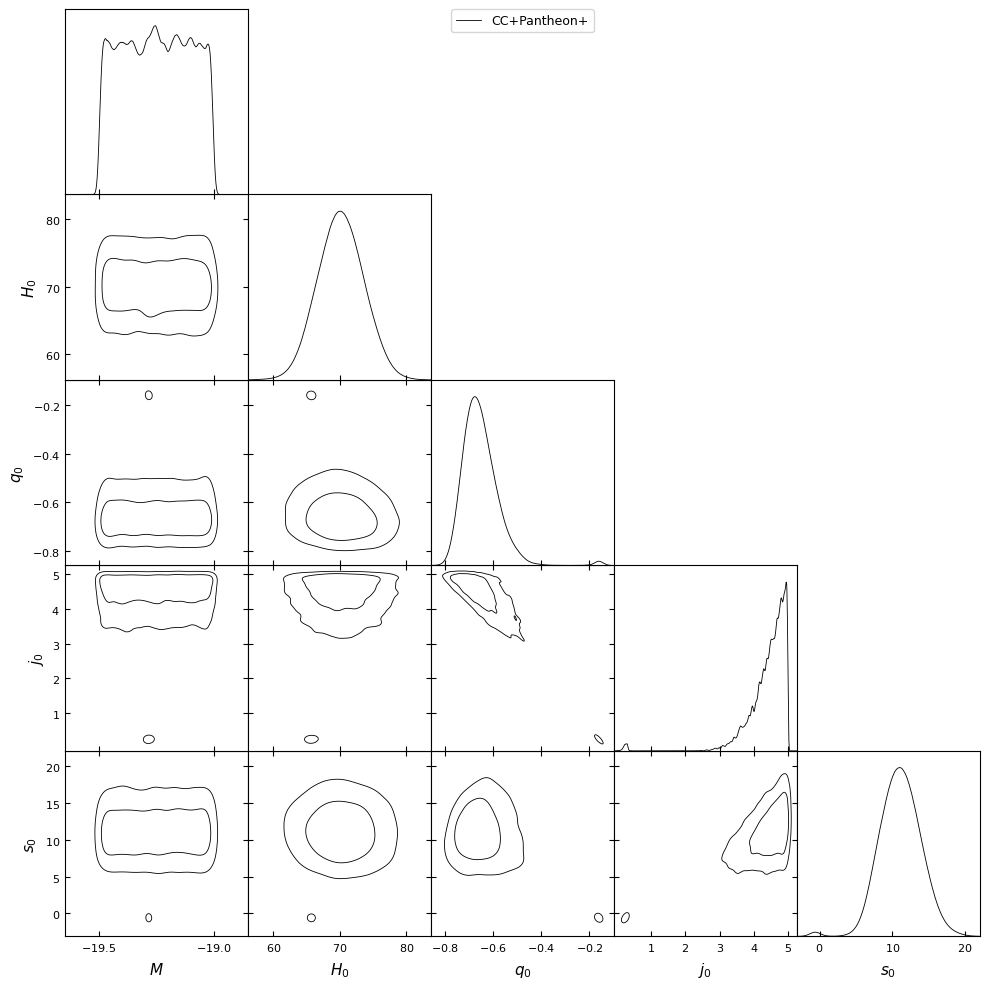

In [71]:
g = plots.getSubplotPlotter()#width_inch=10)
g.triangle_plot([gsamplesHzPP_22], filled=False,legend_labels=['CC+Pantheon+'])
g.export('fig/g_HzPP_22_Badj0_All-triangle.pdf')

In [26]:
resultHzPS_22 = find_bestfit(lnprob,parnames_22,par_mlHzPS_22, 'PS+Hz', 22)
par_mlHzPS_22=resultHzPS_22['x']
print('\n',par_mlHzPS_22,'\n')
print(resultHzPS_22,'\n')

C:\Users\nirk2\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


Maximum likelihood result:
M  =  -19.31169839541314
H0  =  40.0000000643898
q0  =  -0.6719902485124982
j0  =  1.13699362936951
s_0  =  49.99999998742821
chi2min = 505415.40316591243
tempo total: 2.966 seg

 [-19.3116984   40.00000006  -0.67199025   1.13699363  49.99999999] 

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 505415.40316591243
             x: [-1.931e+01  4.000e+01 -6.720e-01  1.137e+00  5.000e+01]
           nit: 382
          nfev: 697
 final_simplex: (array([[-1.931e+01,  4.000e+01, ...,  1.137e+00,
                         5.000e+01],
                       [-1.931e+01,  4.000e+01, ...,  1.137e+00,
                         5.000e+01],
                       ...,
                       [-1.931e+01,  4.000e+01, ...,  1.137e+00,
                         5.000e+01],
                       [-1.931e+01,  4.000e+01, ...,  1.137e+00,
                         5.000e+01]], shape=(6, 5)), array([ 5.054e+05,  5.054e+05,

In [27]:
nstepPS_22 = 9000
samplerHzPS_22 = run_emcee(par_mlHzPS_22,100,lnprob,'PS+Hz', 22, 2.0,nstepPS_22)

  0%|                                                                                         | 0/9000 [00:00<?, ?it/s]C:\Users\nirk2\AppData\Local\Programs\Python\Python313\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
C:\Users\nirk2\AppData\Local\Programs\Python\Python313\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  0%|                                                                                 | 1/9000 [00:00<17:35,  8.53it/s]C:\Users\nirk2\AppData\Local\Programs\Python\Python313\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
C:\Users\nirk2\AppData\Local\Programs\Python\Python313\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar sub

Acceptance fraction: [0.271      0.31911111 0.31822222 0.21333333 0.29988889 0.21
 0.30211111 0.29977778 0.29444444 0.31066667 0.31488889 0.26455556
 0.33311111 0.31244444 0.30788889 0.07711111 0.27444444 0.22966667
 0.32111111 0.309      0.30011111 0.29577778 0.28877778 0.32366667
 0.30477778 0.30922222 0.33555556 0.11477778 0.23188889 0.32833333
 0.29511111 0.27577778 0.30777778 0.30555556 0.32755556 0.27377778
 0.32388889 0.13044444 0.31966667 0.302      0.25011111 0.25266667
 0.30877778 0.27711111 0.17811111 0.147      0.30177778 0.30377778
 0.31533333 0.21355556 0.28966667 0.27377778 0.29355556 0.28566667
 0.24922222 0.30533333 0.15733333 0.21366667 0.29566667 0.22866667
 0.26655556 0.31788889 0.31988889 0.30666667 0.27466667 0.30933333
 0.30677778 0.34788889 0.27388889 0.31088889 0.318      0.15855556
 0.18122222 0.29222222 0.31655556 0.17977778 0.15511111 0.31177778
 0.27488889 0.24966667 0.28055556 0.26844444 0.29888889 0.28122222
 0.30988889 0.284      0.28477778 0.27511111 0.

In [28]:
tauHzPS_22 = samplerHzPS_22.get_autocorr_time(tol=0)
print(tauHzPS_22)
tauHzPS_22max = np.amax(tauHzPS_22)
r = nstepPS_22/tauHzPS_22max
print(r)
print(tauHzPS_22max)
if(r>50):
    print('Convergiu! :)')
else:
    print('Nao convergiu... :(')

[125.86697756 306.57779275 419.08423833 634.06441645 654.57619307]
13.749354307865167
654.5761930690555
Nao convergiu... :(
